In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from itertools import cycle, zip_longest
import math
from torch.utils.data import Dataset, DataLoader, Sampler, TensorDataset
import numpy as np
import random
torch.manual_seed(0)
# random.seed(0)

/home/upamanyu/.pyenv/versions/3.8.15/envs/GWANN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GWASDataset(Dataset):
    def __init__(self, data, labels):
        if not isinstance(data, torch.Tensor):
            self.data = torch.tensor(data, dtype=torch.float)
            self.labels = torch.tensor(labels, dtype=torch.float)
        else:
            self.data = data
            self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return data (seq_len, batch, input_dim), label for index 
        return (self.data[idx], self.labels[idx])
    
class GroupSampler(Sampler):
    def __init__(self, data_source, grp_size, random_seed):
        self.data_source = data_source
        self.grp_size = grp_size
        self.data_size = grp_size*len(self)
        random.seed(random_seed)
        
    def __iter__(self):
        indices = list(range(len(self.data_source)))
        random.shuffle(indices)
        for i in range(0, self.data_size, self.grp_size):
            yield indices[i:i+self.grp_size]

    def __len__(self):
        return len(self.data_source)//self.grp_size

class BalancedBatchGroupSampler(Sampler):
    def __init__(self, dataset, batch_size, grp_size, random_seed):
        self.case_idxs = torch.where(dataset.labels==1)[0]
        self.cont_idxs = torch.where(dataset.labels==0)[0]
        
        assert batch_size % 2 == 0
        self.batch_size = batch_size
        
        self.case_sampler = GroupSampler(self.case_idxs, 
                                         grp_size=grp_size,
                                         random_seed=random_seed)
        self.cont_sampler = GroupSampler(self.cont_idxs, 
                                         grp_size=grp_size,
                                         random_seed=random_seed)
        
    def __iter__(self):
        batch = []
        for case, cont in zip_longest(cycle(self.case_sampler), self.cont_sampler):
            if case is None or cont is None:
                break
            batch.append(self.case_idxs[case])
            batch.append(self.cont_idxs[cont])
            if len(batch) == self.batch_size:
                random.shuffle(batch)
                yield batch
                batch = []
            
        if len(batch) != 0:
            random.shuffle(batch)
            yield batch

    def __len__(self):
        return math.ceil((len(self.cont_sampler)*2)/self.batch_size)



In [5]:
iids = torch.arange(60)
vals = torch.ones((60, 9))
x = torch.column_stack((iids, vals))
labels = torch.cat((torch.ones(30), torch.zeros(30)))

dataset = GWASDataset(x, labels)
batch_sampler = BalancedBatchGroupSampler(dataset, batch_size=4, grp_size=5, random_seed=1)
dataloader = DataLoader(dataset, batch_sampler=batch_sampler)

print(len(dataloader))

c = torch.nn.Conv1d(10, 8, 1)
pool = torch.nn.AvgPool1d(5)
for epoch in range(5):
    print(f'Epoch: {epoch}')
    for i, d in enumerate(dataloader):
        print('Data groups')
        print(d[0][:, :, 0])
        print(f'Labels: {d[1][:, 0]}')
        print()
        # a = c(torch.transpose(d[0], 1, 2))
        # print(a.shape)
        # a = torch.squeeze(pool(a), dim=-1)
        # print(a.shape)
    print('\n')

3
Epoch: 0
Data groups
tensor([[39., 54., 52., 57., 34.],
        [56., 41., 32., 31., 38.],
        [ 1.,  5., 29.,  7., 20.],
        [26., 16., 11., 10., 23.]])
Labels: tensor([0., 0., 1., 1.])

Data groups
tensor([[49., 53., 40., 33., 35.],
        [ 9., 28., 17., 13.,  0.],
        [19., 22.,  6., 12., 21.],
        [48., 45., 44., 37., 46.]])
Labels: tensor([0., 1., 1., 0.])

Data groups
tensor([[14., 15.,  3.,  8.,  2.],
        [58., 47., 50., 59., 30.],
        [55., 43., 36., 51., 42.],
        [24., 25., 27., 18.,  4.]])
Labels: tensor([1., 0., 0., 1.])



Epoch: 1
Data groups
tensor([[59., 57., 49., 33., 31.],
        [ 4., 26., 22.,  9.,  3.],
        [48., 43., 32., 53., 54.],
        [ 0., 24., 23., 20.,  6.]])
Labels: tensor([0., 1., 0., 1.])

Data groups
tensor([[21., 28., 25.,  8., 10.],
        [14.,  2., 19., 17., 11.],
        [39., 38., 40., 34., 45.],
        [44., 51., 41., 56., 42.]])
Labels: tensor([1., 1., 0., 0.])

Data groups
tensor([[ 1., 18., 12., 16., 27

In [3]:
from GWANN.models import GWANNet5, GroupAttention, AttentionMask1
import torch

In [2]:
cov_model = GroupAttention(grp_size=10, inp=9, enc=8, h=[32, 16, 8], 
                           d=[0.5, 0.5, 0.5], out=2, activation=torch.nn.ReLU,
                           att_model=AttentionMask1)

In [4]:
model = GWANNet5(grp_size=10, enc=8, snps=15, cov_model=cov_model,
                 h=[32, 16], d=[0.5, 0.5], out=8, activation=torch.nn.ReLU, 
                 att_model=AttentionMask1)

In [29]:
for np in model.named_parameters():
    if 'cov_model' in np[0]:
        np[1].requires_grad = False
for np in model.named_parameters():
    print(np[0], np[1].requires_grad)

snp_enc.weight True
snp_enc.bias True
snp_model.0.linears.0.weight True
snp_model.0.linears.0.bias True
snp_model.0.linears.1.weight True
snp_model.0.linears.1.bias True
snp_model.0.linears.2.weight True
snp_model.0.linears.2.bias True
snp_model.0.bnorms.0.weight True
snp_model.0.bnorms.0.bias True
snp_model.0.bnorms.1.weight True
snp_model.0.bnorms.1.bias True
snp_model.2.weight True
snp_model.2.bias True
cov_model.grp_enc.weight False
cov_model.grp_enc.bias False
cov_model.end_model.linears.0.weight False
cov_model.end_model.linears.0.bias False
cov_model.end_model.linears.1.weight False
cov_model.end_model.linears.1.bias False
cov_model.end_model.linears.2.weight False
cov_model.end_model.linears.2.bias False
cov_model.end_model.bnorms.0.weight False
cov_model.end_model.bnorms.0.bias False
cov_model.end_model.bnorms.1.weight False
cov_model.end_model.bnorms.1.bias False
cov_model.end_model.bnorms.2.weight False
cov_model.end_model.bnorms.2.bias False
end_model.linears.0.weight True


In [19]:
def m_name(m):
    print(type(m))

In [20]:
model = torch.load('/home/upamanyu/GWANN/Code_AD/NN_Logs/FH_AD_CovSens7_00_GS10_v4_GroupAttention_[32,16,8]_Dr_0.5_LR:0.0001_BS:256_Optim:adam/BCR/0_BCR.pt')
for m in model.named_modules():
    print(m[0])
    m_name(m[1])
    # m_name(m[1])
    
# for param in model.named_parameters():
#     print(param[0])
#     print(param[1][:, 0])
#     break


<class 'GWANN.models.GroupAttention'>
grp_enc
<class 'torch.nn.modules.conv.Conv1d'>
pool
<class 'torch.nn.modules.pooling.AvgPool1d'>
att_mask
<class 'GWANN.models.AttentionMask1'>
att_mask.relu
<class 'torch.nn.modules.activation.ReLU'>
att_mask.soft
<class 'torch.nn.modules.activation.Softmax'>
end_model
<class 'GWANN.models.BasicNN'>
end_model.linears
<class 'torch.nn.modules.container.ModuleList'>
end_model.linears.0
<class 'torch.nn.modules.linear.Linear'>
end_model.linears.1
<class 'torch.nn.modules.linear.Linear'>
end_model.linears.2
<class 'torch.nn.modules.linear.Linear'>
end_model.linears.3
<class 'torch.nn.modules.linear.Linear'>
end_model.dropouts
<class 'torch.nn.modules.container.ModuleList'>
end_model.dropouts.0
<class 'torch.nn.modules.dropout.Dropout'>
end_model.dropouts.1
<class 'torch.nn.modules.dropout.Dropout'>
end_model.dropouts.2
<class 'torch.nn.modules.dropout.Dropout'>
end_model.bnorms
<class 'torch.nn.modules.container.ModuleList'>
end_model.bnorms.0
<class

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/results_Sens8_combined.csv')
df.head()

,Gene,Seed,Chrom,Type,SNPs,Epoch,Acc,Loss,ROC_AUC,Time,P_Loss
0,A1BG-AS1_0,0,19,NaN,9,47,0.497565,0.693240,0.495822,0:02:45.390777,0.401331
1,A1BG-AS1_0,37,19,NaN,9,19,0.494774,0.693247,0.499488,0:01:43.146066,0.397940
2,A1BG-AS1_0,89,19,NaN,9,16,0.500594,0.693272,0.498412,0:01:35.414050,0.416181
3,A1BG-AS1_0,172,19,NaN,9,15,0.488480,0.693193,0.493058,0:01:29.934214,0.334845
4,A1BG-AS1_0,281,19,NaN,9,16,0.486936,0.693525,0.482767,0:01:30.736621,0.510990


Text(0.5, 1.0, 'Cummulative sum of number of SNPs per window')

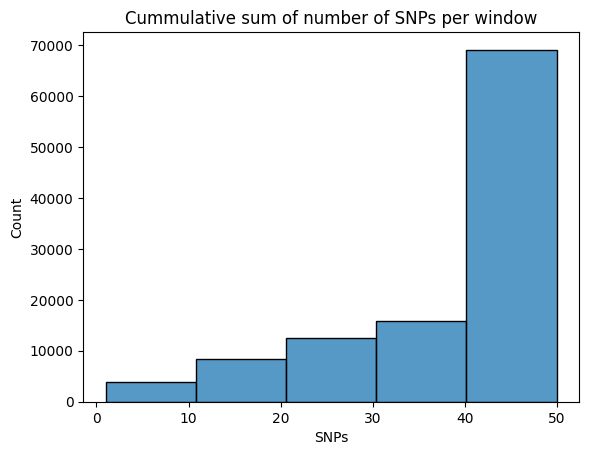

In [16]:
df.drop_duplicates('Gene', inplace=True)
# Plot cummulative histogram
ax = sns.histplot(df['SNPs'], bins=bins, cumulative=True)
plt.title('Cummulative sum of number of SNPs per window')

<AxesSubplot:xlabel='SNPs', ylabel='Count'>

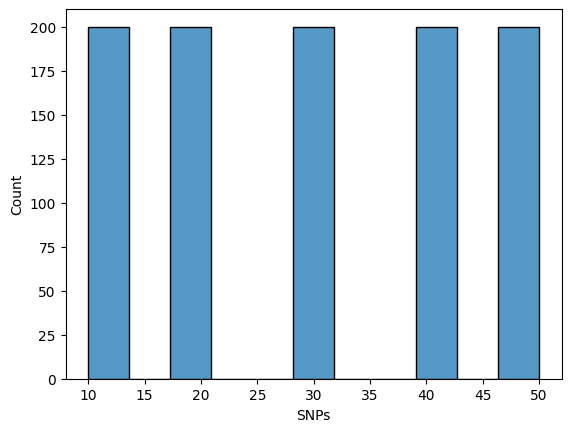

In [3]:
dummy = pd.read_csv('/home/upamanyu/GWANN/Code_AD/results_Sens8_v4/results_Sens8_dummy_combined.csv')
dummy.drop_duplicates('Gene', inplace=True)
sns.histplot(dummy['SNPs'])